In [1]:
"""
@author: Amin
"""
import sys
sys.path.insert(1, '../')

import models
import jax.numpy as jnp
import jax

import params
import inference
import visualizations
import utils
import loader

import os 
%load_ext autoreload
%autoreload 2

/mnt/home/anejatbakhsh/anaconda3/envs/jaxenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Simulate data from PointAttractor/LineAttractor/Saddle dynamics
# For the explanation of the model parameters refer to the original implementation
# Paper: https://www.nature.com/articles/s41593-020-00776-3
# Code: https://github.com/anirgalgali/residual-dynamics

data_params = {
    'dt':.05,
    'sigma':.1,  
    'ntrials':10,
    'time':5,
    'cohs':[-.5,.5],
    'seed': 10,
    'props':{'train':.8,'test':.1,'validation':.1},
    'seeds':{'train':2,'test':0,'validation':3},
    'N':2,
    'obs_noise':0.
}

# You can replace the following by `loader.LineAttractor` or `loader.Saddle` as alternatives
dataloader = loader.PointAttractor(data_params)
_,ts = dataloader.load_train_data()
y = dataloader.data['x_train']


In [3]:
# Select model parameters

# The following parameters work better for the `PointAttractor`. 
# For `Saddle` or `LineAttractor` use:
# use 1e-2, 100 for LineAttractor and PointAttractor
# Saddle: {'type':'RBF','scale': 1e0,'sigma': 10.,'normalizer': 1.}
# use .1 for LineAttractor and PointAttractor
# {'type':'RBF','scale': 1e-3,'sigma': 10.,'normalizer': 1.}
# 'kernel_b': [{'type':'RBF','scale': 1e-2,'sigma': .1,'normalizer': 1.}], 

model_params={
    'D':2,
    'seed':0,
    'kernel_A': [{'type':'RBF','scale': 1e-2,'sigma': 100.,'normalizer': 1.}], 
    'kernel_A_diag': 1e-5,
    'kernel_b': [{'type':'RBF','scale': 1e-3,'sigma': .1,'normalizer': 1.}],
    'kernel_b_diag': 1e-5,
    'kernel_L': [{'type':'RBF','scale': data_params['dt']*data_params['sigma'],'sigma': 100.,'normalizer': 1.}],
    'kernel_L_diag': 1e-5,
    'obs_noise':0.
}

optim_params = {
    'n_iter': 2000,
    'step_size': 1e-3,
    'gamma': 1,
    'scale_L':model_params['kernel_L'][0]['scale'],
}

model = dataloader.__class__.__name__
file='../results/demo/'+model+'/'
save=False

B,T,N = y.shape
D = model_params['D']

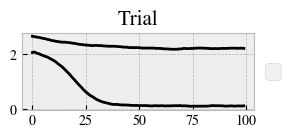

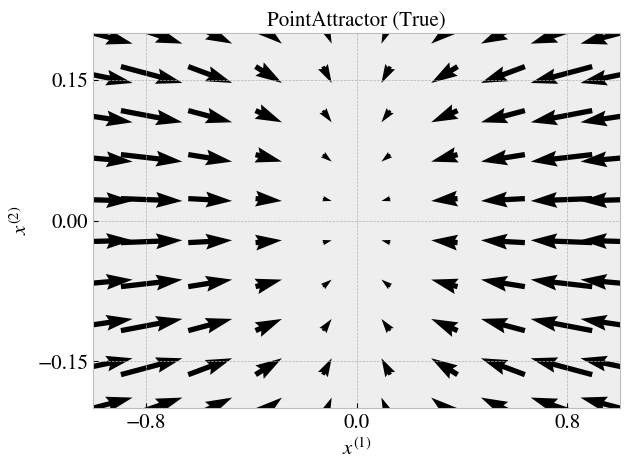

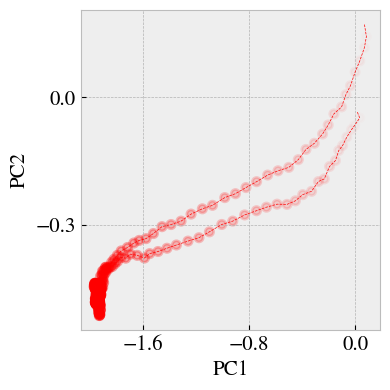

In [4]:
# Some basic visualizations of the data

if not os.path.exists(file): 
    os.makedirs(file)


visualizations.plot_signals(
    [y[0]],
    titlestr='Trial',
    save=save,
    file=file+'trial'
)


if hasattr(dataloader,'A'):
    visualizations.time_var_dynamics(
        [dataloader.A-jnp.eye(D)[None]],
        titlestr=model+' (True)',
        scale=.1/jnp.abs(dataloader.A).max(),
        xlim=[-1,1],
        ylim=[-.2,.2],
        save=save,
        file=file+'A_true'
    )

visualizations.plot_states(
    [y[0],y[1]],
    ['y','y'],
    legend=False,
    save=save,
    file=file+'states'
)

In [5]:
# Creating model instances and fitting to the data

seed = model_params['seed']
key = jax.random.PRNGKey(seed)

kernel_A = utils.get_kernel(model_params['kernel_A'],model_params['kernel_A_diag'])
kernel_b = utils.get_kernel(model_params['kernel_b'],model_params['kernel_b_diag'])
kernel_L = utils.get_kernel(model_params['kernel_L'],model_params['kernel_L_diag'])

gps = {
    'A': models.GaussianProcess(kernel_A,D,D),
    'b': models.GaussianProcess(kernel_b,D,1),
    'L': models.GaussianProcess(kernel_L,D,D)
}


kA, kb, kL, key = jax.random.split(key,4)

_joint_params = params.ParamsGPLDS(
    emissions =  params.ParamsEmission(
        Cs = jnp.eye(D),
        ds = jnp.zeros(D)
    ),
    likelihood = params.ParamsNormalLikelihood(
        scale_tril=model_params['obs_noise']*jnp.eye(N)
    )
)

initial = models.InitialCondition(D)
lds = models.TimeVaryingLDS(D=D,initial=initial)
emission = models.LinearEmission(D=D,N=N)
likelihood = models.NormalConditionalLikelihood(N)
joint = models.GPLDS(gps,lds,emission,likelihood)


_recognition_params = params.ParamsGP(
    As = gps['A'].sample(kA,ts[0][1:]),
    bs = gps['b'].sample(kb,ts[0]),
    Ls = gps['L'].sample(kL,ts[0])
)

recognition = inference.Delta()

Loss: -695.32, Log Marginal: 695.32, Log Prior: -31109.75: 100%|██████████| 1000/1000 [00:22<00:00, 44.66it/s]  


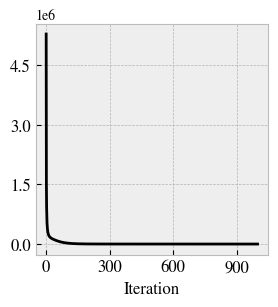

In [6]:
# Fitting the model using MAP inference and marginal likelihood maximization

(joint_params, recognition_params), loss = inference.fit_map(
    joint,
    _joint_params,
    recognition,
    _recognition_params,
    y,
    ts,
    n_iter=1000,
    step_size=.001,
    gamma=0,#optim_params['gamma']
)

visualizations.plot_loss(
    loss,
    save=save,
    file=file+'loss'
)

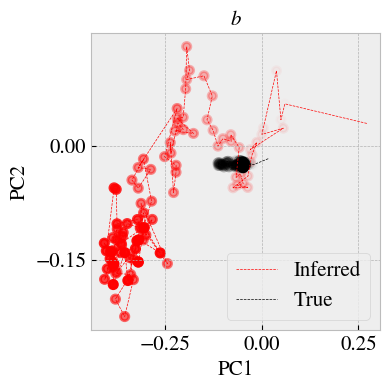

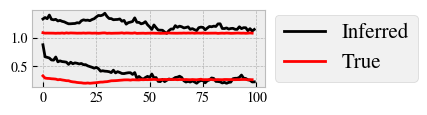

In [8]:
# Inferring latents and model parameters and visualizing the results

i = 0 # trial number
latents = recognition(recognition_params,ts[i])


if 'b_train' in dataloader.data:
    visualizations.plot_states(
        [latents.bs.squeeze(),dataloader.data['b_train'][i]],
        ['Inferred','True'],
        titlestr='$b$',
        save=save,
        file=file+'b_states'
    )

    visualizations.plot_signals(
        [latents.bs.squeeze(),dataloader.data['b_train'][i]],
        labels=['Inferred','True'],
        margin=.2,
        save=save,
        file=file+'b_signals'
    )




/mnt/home/anejatbakhsh/Desktop/Projects/GPLDS/codes/notebooks/../visualizations.py:184: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


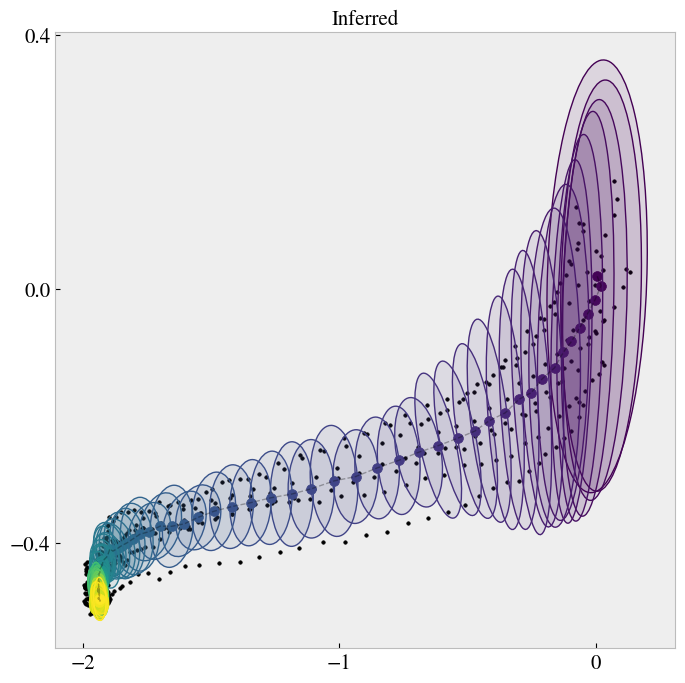

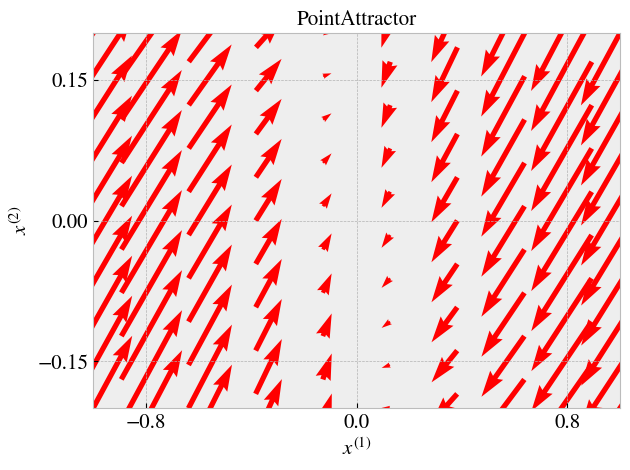

In [10]:
(mus, sigmas), (mus_obs, sigmas_obs) = joint.filter(joint_params,latents=latents)


visualizations.visualize_pc(
    mus_obs[:,None],sigmas_obs,
    pc=y,
    linewidth=1,
    titlestr='Inferred',
    save=save,
    file=file+'pc_inferred'
)


visualizations.time_var_dynamics(
    [latents.As[0]-jnp.eye(D)[None]],
    titlestr=model,
    colors=['r'],
    linewidth=.01,
    scale=1.,
    xlim=[-1,1],
    ylim=[-.2,.2],
    save=False,
    file=file+'A'
)